In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%pylab inline
import sys
sys.path.append('../../src/')
from helpers import *
from plothelpers import *
from MultiplicativeBaseGame import *
from random import sample
import json, pickle
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Preprocessing

In [5]:
# # Migrate data
# for nmax in range(11, 111):
#     res = pickle.load(open(f'HUR07/HUR07-nmax-{nmax}.pickle', 'rb'))
#     fav_bases = array(res[0])
#     successes = array(res[1])
#     base_counts = fav_bases.sum(axis=2)
#     num_bases = fav_bases.sum(axis=3).sum(axis=2)
#     num_unique_bases = (fav_bases.sum(axis=2) > 0).sum(axis=2)
    
#     _base = os.path.join('../../results/HUR07', f'HUR07-nmax-{nmax}')
#     np.save(_base+'-base-counts.npy', base_counts, allow_pickle=False)
#     np.savetxt(_base+'-num-bases.txt.gz', array(num_bases))
#     np.savetxt(_base+'-num-unique-bases.txt.gz', array(num_unique_bases))
#     np.savetxt(_base+'-successes.txt.gz', array(successes))
    
#     params = json.load(open(f'HUR07/HUR07-nmax-{nmax}-setup.json', 'r'))
#     json.dump(params, open(_base+'-params.json', 'w'))

In [37]:
# Merge runs
for nmax in range(11, 111):
    name = f'HUR07-nmax-{nmax}'
    print(name)
    res1 = load_MBG_simulation('results/', name)
    res2 = load_MBG_simulation('../../results/HUR07-part1/', name)
    merged = [np.concatenate((a, b), axis=0) for a, b in zip(res1[:4], res2[:4])]
    params = res2[-1]
    del params['bases']
    save_MBG_simulation(params, merged, '../../results/HUR07/', name)

HUR07-nmax-110


In [82]:
# Preprocess raw data
data, cols = [], []
for nmax in range(11,111):
    res = load_MBG_simulation('../../results/HUR07/', f'HUR07-nmax-{nmax}')
    base_counts, _, _, _, params = res
    
    final_states = base_counts[:,-1,:]
    data += final_states.mean(axis=0).tolist()
    data += final_states.std(axis=0).tolist()
    
    cols += [(f'nmax-{nmax}', f'base-{b}', 'mean') for b in params['bases']]
    cols += [(f'nmax-{nmax}', f'base-{b}', 'std') for b in params['bases']]

    
data = pd.DataFrame(data)
data.index = pd.MultiIndex.from_tuples(cols)

# Reformat df/
data = data.unstack(level=[1,2])
data = data[0]
data.index = data.index.str.replace('nmax-', '').astype(int)
data.sort_index(axis=0, inplace=True)
data = data.reindex_axis(sorted(data.columns), axis=1)
data.index.name='nmax'

data.to_csv('../../results/HUR07/HUR07.csv')
data.to_csv('HUR07.csv')

# Plot

In [83]:
data = pd.read_csv('HUR07.csv', header=[0,1], index_col=0)

In [157]:
# Compute num expressions
def num_expressions(n, b, B, simplify=True):
    if n > b*b + B: return 0
    if simplify and n%b == 0: return 1 
    return 2 if n%b <= B-b else 1

B = 10
simplify = True
exprs = []
for n_max in data.index:
    counts = []
    for b in [6,7,8,9,10]:
        nums = arange(11, n_max+1)
        count = sum([num_expressions(n, b, B, simplify) for n in nums])
        counts.append(count)
        
    exprs.append(counts)

# Normalize results
exprs = array(exprs)
exprs = exprs/exprs.sum(axis=1)[:,np.newaxis]

# Exponentiated and restricted version
eta=5
exprs2 = np.copy(exprs)
for i in range(5):
    exprs2[:,i][(i+6)**2:] = 0
exprs2 = (exprs2**eta) / (exprs2**eta).sum(axis=1)[:, np.newaxis]

In [158]:
# Means 
means = data.reorder_levels([1,0], axis=1)['mean']
means = means.divide(means.sum(axis=1), axis=0)
means.columns = means.columns.str.replace('base-','').astype(int)
means.sort_index(axis=1, inplace=True)

/Users/Bas/anaconda/envs/thesis2/lib/python3.6/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


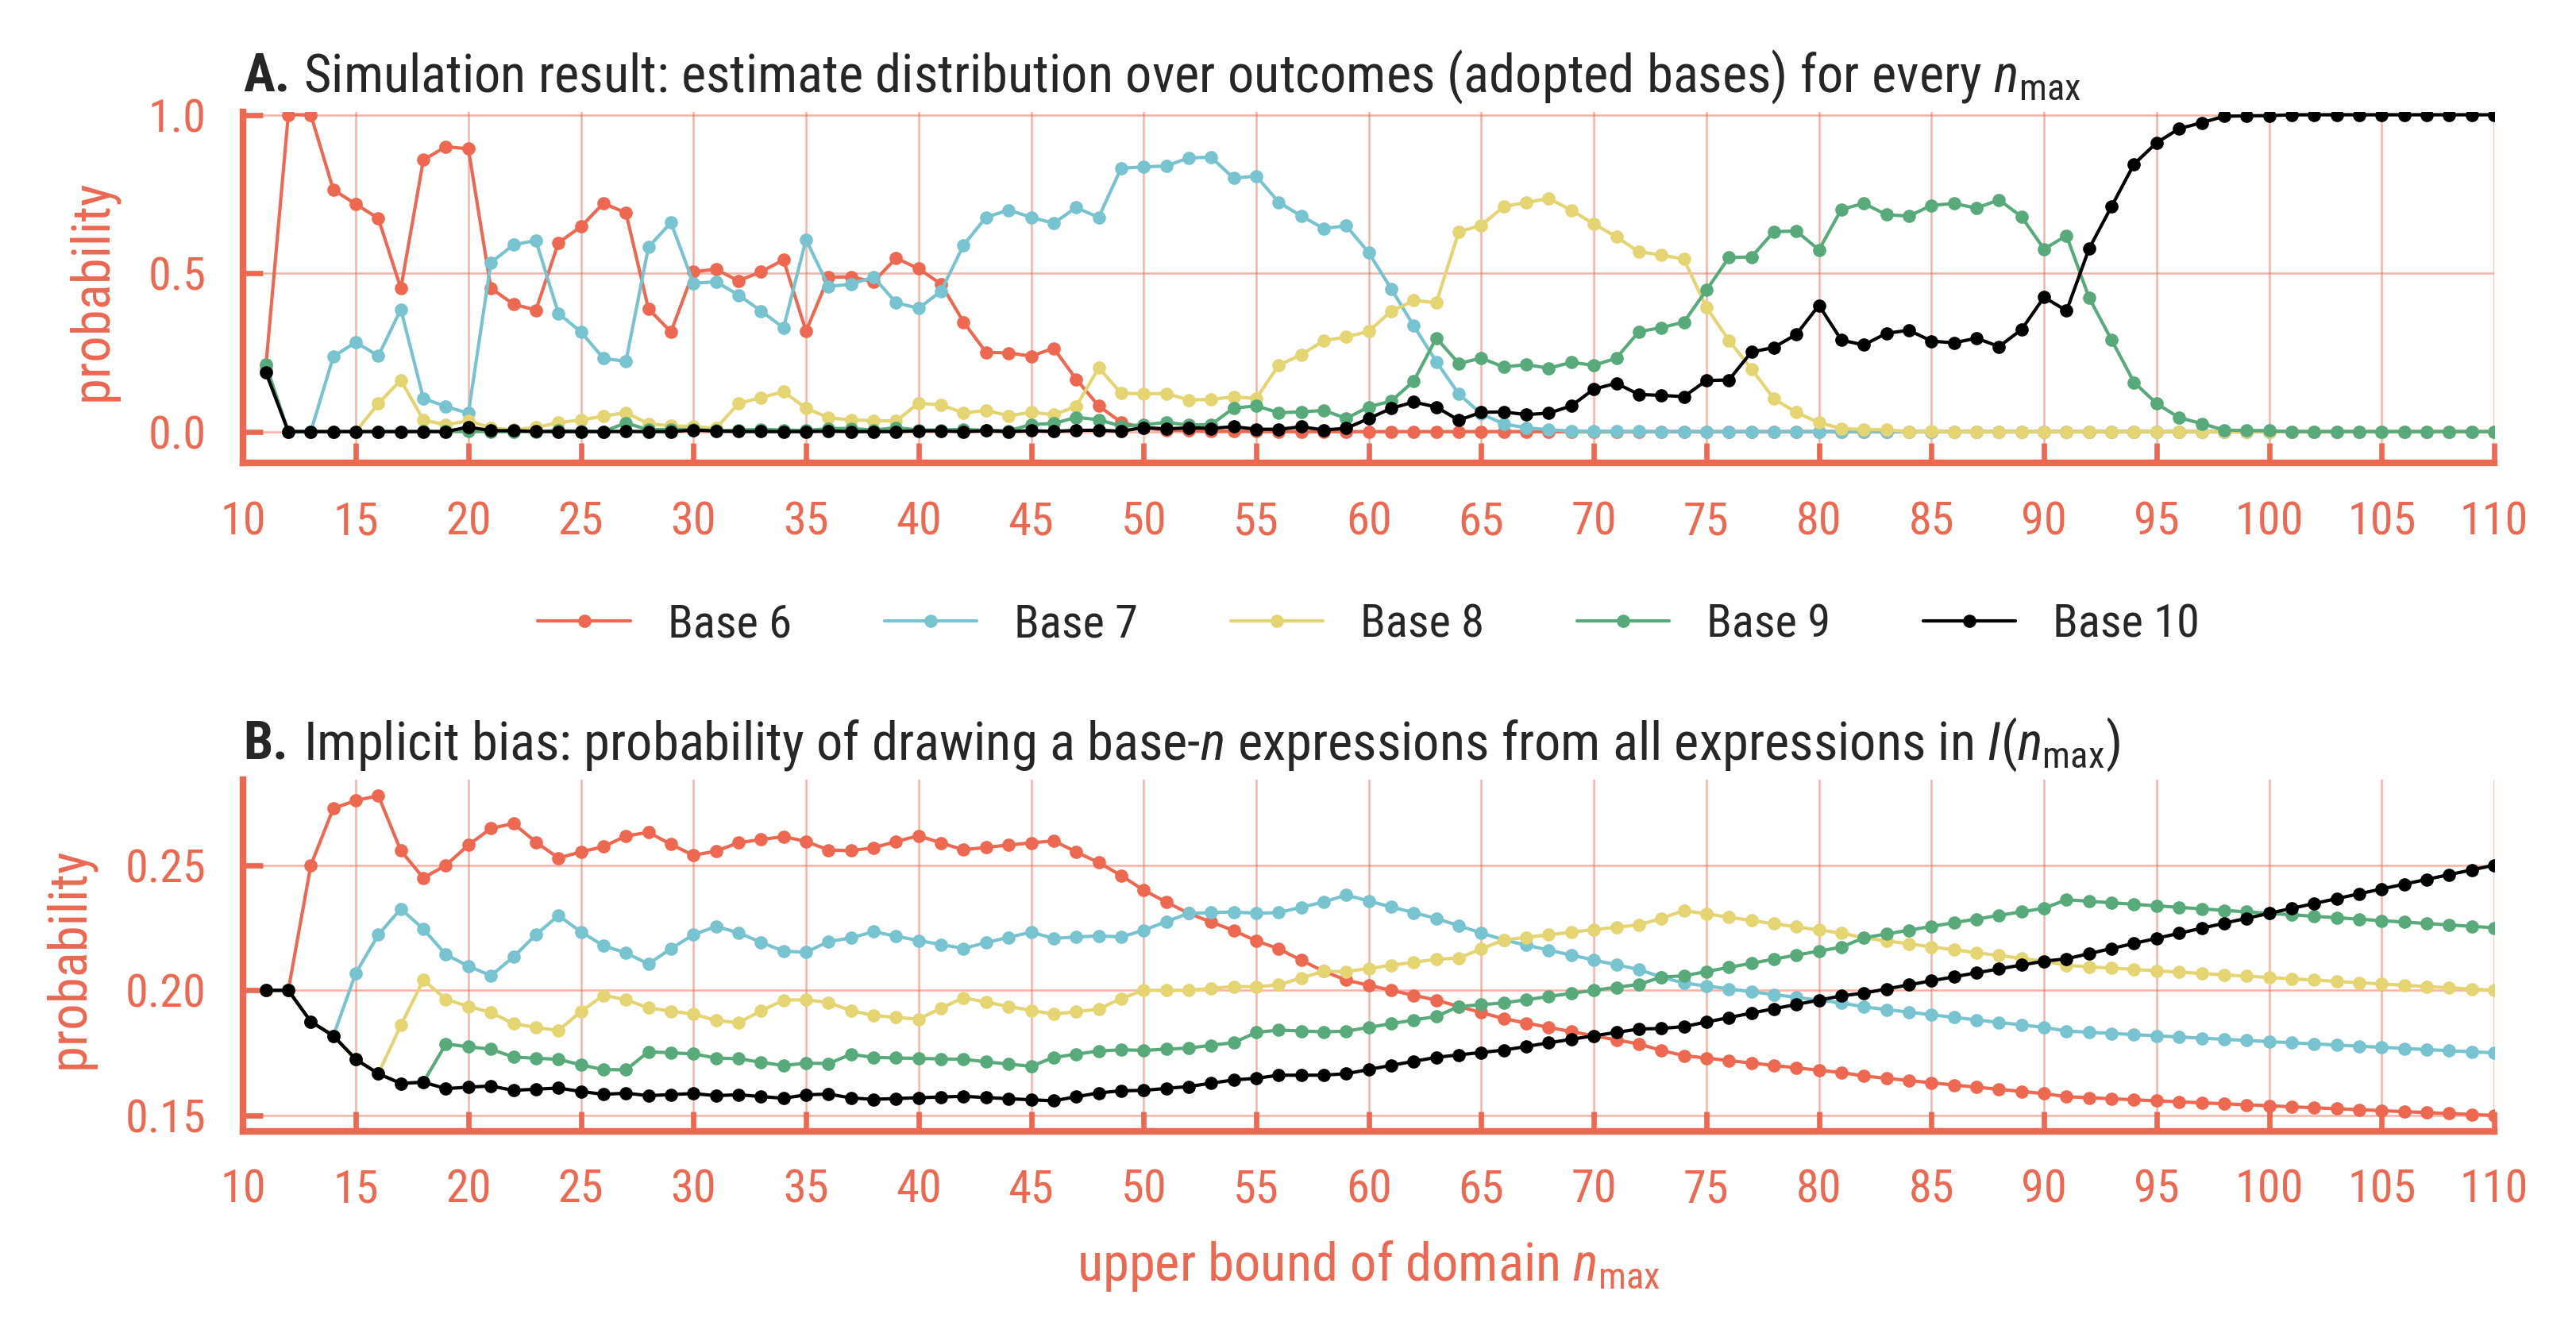

In [162]:
# Plot
figure(figsize=cm2inch(12,9))
xs = means.index

colors = plt.rcParams['axes.color_cycle']
del colors[0]
colors[-1] = '#000000'

if True:
    ax1 = subplot(311)
    for b in range(5):
        plot(xs, means[b+6], 'o-', lw=.5, ms=2, color=colors[b])
#         bar(xs-.5, means[b+6], .9, 
#             bottom = means.iloc[:,:b].sum(axis=1),
#             lw=0, alpha=.15, color=colors[b])

    title('Simulation result: estimate distribution over outcomes (adopted bases) for every $n_{\mathrm{max}}$')
    ylim(-.1,1.01)
    ylabel('probability ')

if True:
    ax2 = subplot(312)
    for i, expr in enumerate(exprs.T):
        plot(xs, expr, 'o-', lw=.5, ms=2, 
             label=f'Base {i+6}', color=colors[i])
    title('Implicit bias: probability of drawing a base-$n$ expressions from all expressions in $I(n_{\mathrm{max}})$')
    xlabel('upper bound of domain $n_{\mathrm{max}}$')
    ylabel('probability ')
    legend(ncol=5, bbox_to_anchor=(.5,1.3), loc='lower center', mode='extend')

restyle_title(ax1,ax2, y=1.1)
for ax in [ax1,ax2]:
    ax.locator_params(nbins=4, axis='y')
    ax.locator_params(nbins=20, axis='x')
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set_xlim(10, 110)
sns.despine()

subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=.9)
savefig('HUR07-results.pdf', bbox_inches='tight')
copyfig('HUR07-results.pdf')
# savefig('HUR07-results-exponentiated-restricted.pdf', bbox_inches='tight')
# copyfig('HUR07-results-exponentiated-restricted.pdf')

# Old stuff

In [ ]:
def dist_interval(nmax, B, simplify=True):
    nmin = B+1
    K = B/2
    ns = arange(nmin, nmax+1)
    dist = array([
        [num_expressions(n, b, B, simplify) for n in ns]
        for b in arange(K+1, B+1)
    ])
    return dist.sum(axis=1) / dist.sum()

d = dist_interval(100, 10)

In [ ]:
dist = [[num_expressions(n, b, 10) for b in range(6,11)] 
        for n in range(11, 111)]
dist = array(dist) / array(dist).sum(axis=1)[:, np.newaxis]